# import libraries & Load QMUL dataset

In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np

from torch.autograd import Variable
from PIL import Image

from model.model import PixEncoder, SeqDecoder
from model.model import PixDecoder, SeqEncoder
from config import Config

import numpy as np
from utils.draw import draw_strokes
import h5py

import cv2
import matplotlib.pyplot as plt

# Load trained models

In [17]:
config_name = "quickdraw_config4"

config = Config(f"./configs/{config_name}.yml").get_config()
weight_epoch = 355
device = "cpu"

# pix_enc = PixEncoder(config)
# pix_dec = PixDecoder(config)
seq_enc = SeqEncoder(config)
seq_dec = SeqDecoder(config)

# pix_enc.load_state_dict(torch.load(f"./weights/Portrait/2022-11-19-png-svg-not-matched/pix_enc_{weight_epoch}.pt", map_location=device))
# pix_dec.load_state_dict(torch.load(f"./weights/Portrait/2022-11-19-png-svg-not-matched/pix_dec_{weight_epoch}.pt", map_location=device))
seq_enc.load_state_dict(torch.load(f"./weights/{config_name}/seq_enc_{weight_epoch}.pt", map_location=device))
seq_dec.load_state_dict(torch.load(f"./weights/{config_name}/seq_dec_{weight_epoch}.pt", map_location=device))
# seq_enc.load_state_dict(torch.load(f"./weights/detail_eyes/seq_enc_{weight_epoch}.pt", map_location=device))
# seq_dec.load_state_dict(torch.load(f"./weights/detail_eyes/seq_dec_{weight_epoch}.pt", map_location=device))
# seq_enc.load_state_dict(torch.load(f"./weights/Qu/seq_enc_25000.pt"))
# seq_dec.load_state_dict(torch.load(f"./weights/QuickDraw/seq_dec_25000.pt"))
seq_dec.training = False

# pix_enc.to(device)
# pix_dec.to(device)
seq_dec.to(device)
seq_enc.to(device)

# pix_enc.eval()
# pix_dec.eval()
seq_dec.eval()
seq_enc.eval()

# device = config.device

{'hypers': {'encoder_hidden_size': 256, 'decoder_hidden_size': 512, 'num_layers': 1, 'Nz': 128, 'dropout': 0.9, 'M': 20, 'max_seq_length': 131, 'lr': 0.001, 'eta_min': 0.01, 'batch_size': 512, 'R': 0.95, 'KL_min': 0.2, 'wKL': 0.5, 'lr_decay': 0.9999, 'min_lr': 0.0001, 'grad_clip': 5.0, 'in_channels': 1, 'img_size': 256, 'img_crop': 224, 'pix_enc_hdims': [32, 64, 128, 256, 256], 'pix_dec_hdims': [256, 256, 128, 64, 32]}, 'data': {'quick_draw': '/home/joono/media/MinLab/sketch-photo2seq-torch/datasets/QuickDraw/shoes/npz/shoe.npz', 'qmul_train': None, 'qmul_test': None, 'portrait_npy': None, 'portrait_png': None}, 'train': {'quickdraw': {'epochs': 1000, 'save_iter': 5, 'weights_save': './weights/quickdraw_config4', 'resume': False, 'start_epoch': None}}, 'device': None, 'tensorboard_log': 'runs/quickdraw_config4'}
 device: cuda


SeqEncoder(
  (lstm): LSTM(5, 256, dropout=0.9, bidirectional=True)
  (mu): Linear(in_features=512, out_features=128, bias=True)
  (sigma): Linear(in_features=512, out_features=128, bias=True)
)

# Load DataLoader

In [18]:
# from data.dataloader import QMULLoader, QuickDrawLoader, Portra
from data.custom_dataloader import PortraitDataset, QuickDrawDataset

# dset = QMULLoader(config)
dset = QuickDrawDataset(config)
# dset = PortraitDataset(config)
batch_size = 1
loader = torch.utils.data.DataLoader(
    dset,
    shuffle=False,
    batch_size=batch_size,
)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config["hypers"]["img_size"], config["hypers"]["img_size"])),
    transforms.CenterCrop((config["hypers"]["img_crop"], config["hypers"]["img_crop"])),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

Nmax: 69


# sample

In [19]:
from utils.draw import to_normal_strokes
import random

def sample_s2s(seq_enc, seq_dec, sketch, device, max_len=250, temperature=1.0, greedy_mode=False):
    """Samples a sequence from a pre-trained model."""

    def adjust_temp(pi_pdf, temp):
        pi_pdf = np.log(pi_pdf) / temp
        pi_pdf -= pi_pdf.max()
        pi_pdf = np.exp(pi_pdf)
        pi_pdf /= pi_pdf.sum()
        return pi_pdf

    def get_pi_idx(x, pdf, temp=1.0, greedy=False):
        """Samples from a pdf, optionally greedily."""
        if greedy:
            return np.argmax(pdf)
        pdf = adjust_temp(np.copy(pdf), temp)
        accumulate = 0
        for i in range(0, pdf.size):
            accumulate += pdf[i]
            if accumulate >= x:
                return i
        print('Error with sampling ensemble.')
        return -1

    def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
        if greedy:
            return mu1, mu2
        mean = [mu1, mu2]
        s1 *= temp * temp
        s2 *= temp * temp
        cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
        x = np.random.multivariate_normal(mean, cov, 1)
        return x[0][0], x[0][1]

    
    # for sketch, length, images, target in loader:

    sketch = torch.stack([sketch])

    sketch = sketch.permute((1, 0, 2))
    z, _, _ = seq_enc(sketch, batch_size)

    s = Variable(torch.stack([torch.Tensor([0, 0, 1, 0, 0])]).to(device)).unsqueeze(0)
    batch_init = torch.cat([s])
    z_stack = torch.stack([z])
    inputs = torch.cat([batch_init, z_stack], 2)

    o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, hidden, cell = seq_dec(inputs, z, 1) # batch size is 1
    pen_state = torch.argmax(o_pen)

    greedy = greedy_mode
    temp = temperature

    strokes = []
    iter = 0
    while pen_state != 2 and iter < max_len:
        iter += 1
        o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, hidden, cell = seq_dec(inputs, z, 1, (hidden, cell))

        # [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, o_pen_logits] = gmm_coef
        # top 6 param: [1, 20], o_pen: [1, 3], next_state: [1, 1024]

        o_pi = o_pi.squeeze(0).detach().cpu().numpy()
        o_mu1 = o_mu1.squeeze(0).detach().cpu().numpy()
        o_mu2 = o_mu2.squeeze(0).detach().cpu().numpy()
        o_sigma1 = o_sigma1.squeeze(0).detach().cpu().numpy()
        o_sigma2 = o_sigma2.squeeze(0).detach().cpu().numpy()
        o_corr = o_corr.squeeze(0).detach().cpu().numpy()
        o_pen = o_pen.squeeze(0).detach().cpu().numpy()

        idx = get_pi_idx(random.random(), o_pi[0], temp, greedy)
        pen_state = get_pi_idx(random.random(), o_pen[0], temp, greedy)

        eos = [0, 0, 0]
        eos[pen_state] = 1
        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                              o_sigma1[0][idx], o_sigma2[0][idx],
                                              o_corr[0][idx], np.sqrt(temp), greedy)

        strokes.append((next_x1, next_x2, eos[0], eos[1], eos[2]))
        s[0, 0, 0] = next_x1
        s[0, 0, 1] = next_x2
        s[0, 0, 2:] = torch.eye(3)[pen_state] 
        inputs = torch.cat([s, z_stack], dim=2)

    # strokes in stroke-5 format, strokes in stroke-3 format
    return to_normal_strokes(np.array(strokes))

input
M :48, L: 21


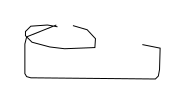

output
M :2, L: 21


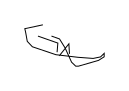

output
M :1, L: 23


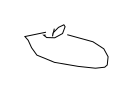

output
M :0, L: 22


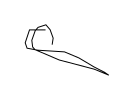

output
M :1, L: 22


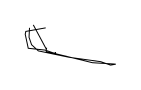

output
M :0, L: 21


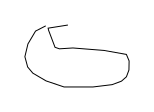

output
M :2, L: 20


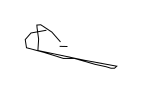

output
M :1, L: 22


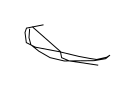

output
M :4, L: 20


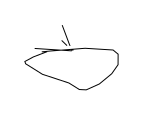

output
M :2, L: 20


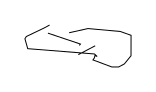

output
M :4, L: 20


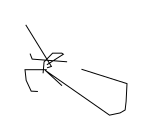

In [21]:
# sketch, length, (mask, dx, dy, p) = dset.__getitem__(np.random.randint(0, 1000))

sketch_idx = 0

sketch, length, (mask, dx, dy, p) = dset.__getitem__(sketch_idx)
sketch_ = sketch[:, :3]
sketch_[:, 2] = 1 - sketch_[:, 2]

import os
if not os.path.isdir(f"{sketch_idx}"):
    os.mkdir(f"{sketch_idx}")

print("input")
draw_strokes(sketch_, factor=0.04, svg_filename=f"./{sketch_idx}/input.svg")

temps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for t in temps:
    Nmax = dset.Nmax
    sample_draw = sample_s2s(seq_enc, seq_dec, sketch, device, max_len=Nmax, temperature=0.1 * t)

    print("output")
    draw_strokes(sample_draw, factor=0.04, svg_filename=f"./{sketch_idx}/{t}.svg")

In [ ]:
"""
To check whether data is properly prepared

"""

samples = range(0, 2001, 100)

for s in samples:
    sketch, length, _, (mask, dx, dy, p) = dset.__getitem__(s)
    sketch_ = sketch[:, :3]
    sketch_[:, 2] = 1 - sketch_[:, 2]

    import os
    if not os.path.isdir(f"{sketch_idx}"):
        os.mkdir(f"{sketch_idx}")

    draw_strokes(sketch_, factor=0.05, svg_filename=f"./{sketch_idx}/input.svg")